# Welcome

This notebook is a stream lined version of the original for those who are familiar with the settings

In [0]:
!nvidia-smi
!pip install -U git+https://www.github.com/microfossil/particle-classification.git

## If Google Drive

Mount google drive if necessay:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive



## If Computer Upload

Create datasets directory:


In [0]:
import os

os.makedirs("/content/datasets/", exist_ok=True)

Upload to datasets then unzip:

In [0]:
!unzip PASTE_HERE

# Training

Using TensorFlow backend.
W0819 00:50:55.169646 139669380278144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/miso/training/model_trainer.py:30: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.



@Downloading dataset https://1drv.ws/u/s!AiQM7sVIv7fah4MN2gWCXDWX_DT0OA?e=Eu3lZh...
@Parsing image directory...
@Moving classes with not enough images to 'other'...
 - (  196 images) aa
 - (  224 images) aj
 - (  209 images) al
 - (  222 images) c
 - (  202 images) ca
 - (  198 images) co
 - (  211 images) dm
 - (  237 images) p
@1699 images in 8 classes
@Loading images...

@Loading images 5%
@Loading images 11%
@Loading images 17%
@Loading images 23%
@Loading images 29%
@Loading images 35%
@Loading images 41%
@Loading images 47%
@Loading images 52%
@Loading images 58%
@Loading images 64%
@Loading images 70%
@Loading images 76%
@Loading images 82%
@Loading images 88%
@Loading images 94%
@Generating model


W0819 00:51:38.654947 139669380278144 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


@Training
|         |         |         |         |         |         |         |         |   #     |     *   | Epoch:   0.0 Batch:    20 #Train:  83.6% (0.5243), *Val:  96.2% (0.1245) !Prob  1.0 Time:  0.00s
|         |         |         |         |         |         |         |         |         |      #  | Epoch:   1.0 Batch:    40 #Train:  96.8% (0.1074), *Val:  96.9% (0.1026) !Prob  1.0 Time:  0.10s
|         |         |         |         |         |         |         |         |         |       # | Epoch:   2.0 Batch:    60 #Train:  98.0% (0.0511), *Val:  98.4% (0.0553) !Prob  1.0 Time:  0.11s
|         |         |         |         |         |         |         |         |         |        #| Epoch:   3.0 Batch:    80 #Train:  99.3% (0.0178), *Val:  98.6% (0.0451) !Prob  1.0 Time:  0.10s
|         |         |         |         |         |         |         |         |         |        *# Epoch:   4.0 Batch:   100 #Train:  99.8% (0.0119), *Val:  98.8% (0.0509) !Prob  1.0 Time:  0

W0819 00:52:32.062287 139669380278144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/miso/save/freezing.py:54: simple_save (from tensorflow.python.saved_model.simple_save) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
W0819 00:52:32.063557 139669380278144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0819 00:52:34.521189 139669380278144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/tools/fr

@Complete


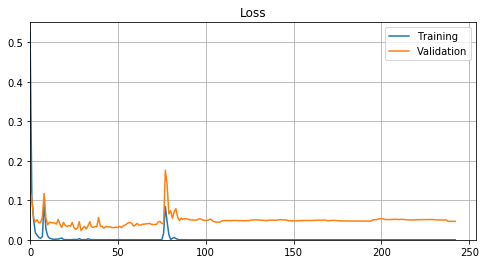

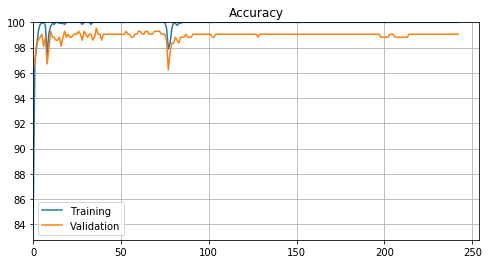

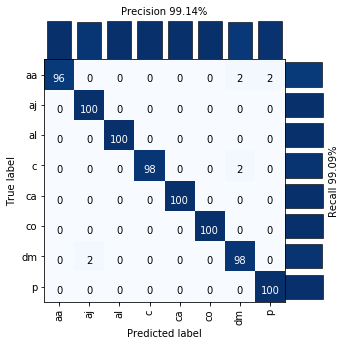

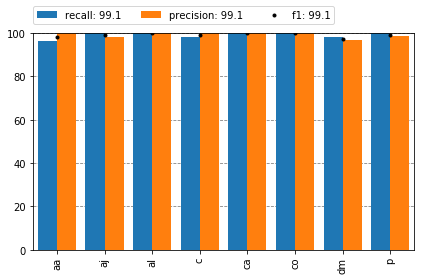

In [1]:
"""
Example image classification with the MISO library
"""
from miso.training.model_params import default_params
from miso.training.model_trainer import train_image_classification_model

params = default_params()

# OVERVIEW -------------------------------------------------------------------------------------------------------------
# A short name to describe the network
# The name will be also be used to construct the output directory name

params['name'] = 'image_classification_example'

# Longer description of the network
# The longer description will be saved in the xml description of the network
# Set to None to be auto-generated

params['description'] = None

# CNN TOPOLOGY ---------------------------------------------------------------------------------------------------------
# The type of network
# Choices are:
# Network       Description
# -----------   -----------------------------------------------------------------------
# base_cyclic   Classic sequential layer CNN with cyclic layers and batch normalisation
# resnet18      Residual network (uses skip connections) with 18 layers
# resnet34      Residual network with 34 layers
# resnet50      Residual network with 50 layers
# resnet50_tl   Transfer learning using ResNet50 (VERY FAST)

params['type'] = 'resnet50_tl'

# Base Cyclic configurable parameters
# The base_cyclic network is a custom design and can be configured further
# - filters: 4, 8, 16, 32, etc. More filters may improve accuracy.
params['filters'] = 4
# - use batch normalisation: True / False. Batch normalisation typically improves accuracy.
params['use_batch_norm'] = True
# - global pooling: None, 'avg', 'max'
params['global_pooling'] = None
# - activation: 'relu', 'elu', 'selu'
params['activation'] = 'relu'

# The input dimensions of the image
# For height and width:
# - height and width should be the same for particle images to ensure proper rotation augmentation
# - 128 x 128 works well for simple particles
# - 224 x 224 is the size ResNet has been designed for
# - height and width will automatically be set when using transfer learning
# - NOTE: Larger images take longer to train!
# For number of channels:
# - using channels = 1 will convert the images to greyscale (recommended if colour is not a feature)
# - using channels = 3 will leave the image in RGB mode

params['img_height'] = 128
params['img_width'] = 128
params['img_channels'] = 1

# TRAINING -------------------------------------------------------------------------------------------------------------
# Number of images presented per training iteration
# 64 is recommended. Lower to 32 or 16 if getting out-of-memory errors

params['batch_size'] = 64

# Maximum epochs after which training is definitely stopped
# Keep at a high number like 10000 as training will normally
# be stopped by the adaptive learning rate system

params['max_epochs'] = 10000

# Number of epochs and drops for the adaptive learning rate system. (ALR)
# ALR will monitor the last alr_epochs worth of epochs during training.
# If the loss is not decreasing, the learning rate will be dropped by half.
# After alr_drops times of drops, training is stopped.

params['alr_epochs'] = 40
params['alr_drops'] = 4


# AUGMENTATION ---------------------------------------------------------------------------------------------------------
# Use augmentation (transfer learning automatically sets this to false)
params['use_augmentation'] = False

# INPUT ----------------------------------------------------------------------------------------------------------------
# Input data source
# Either a local directory, e.g. r'C:\Users\my_name\Documents\Data\particle_training_set\'
# or a direct download link, e.g. r'https://1drv.ws/u/s!AiQM7sVIv7fah4MN2gWCXDWX_DT0OA?e=Eu3lZh'

params['input_source'] = r'https://1drv.ws/u/s!AiQM7sVIv7fah4MN2gWCXDWX_DT0OA?e=Eu3lZh'

# Minimum number of images per class for that class to be included
# Recommended that this value is at least 20

params['data_min_count'] = 40

# Fraction of images used for testing to calculate accuracy etc

params['data_split'] = 0.25

# Weight the classes by count
# If the number of images in each class varies significantly, training may try to improve accuracy by maximising the
# over-represented classes at the expense of the under-represented. Using class weights will weight the
# under-represented classes more highly, usually improving their accuracy.

params['use_class_weights'] = True

# OUTPUT ---------------------------------------------------------------------------------------------------------------
# Root directory to save trained model, graphs etc.(A sub-directory will be automatically created for each training run)
# Can be an absolute path, e.g. r'C:\Users\my_name\Documents\TrainedModels\'
# Or a relative path to the directory from which this script was run, e.g. r'output'

params['output_dir'] = r'output'

# What format to save the trained model in
# frozen: Frozen format used for inference (recommended)
# saved_model: Tensorflow Saved Model format (graph and weights in separate files)
# None: Don't save a model

params['save_model'] = 'frozen'

# Whether to estimate mislabeled images or not
# params['save_mislabeled'] = True

# RUN ------------------------------------------------------------------------------------------------------------------
# model: Trained Keras model for image classification in inference mode
# vector_model: Sub-graph of previous model for generating feature vectors
# data_source: The training data
# results: Results of training (accuracy, precision, recall, f1score, etc)

model, vector_model, data_source, results = train_image_classification_model(params)


Zip for download if desired:

In [0]:
!zip -r /content/output.zip PASTE_PATH_HERE